In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.oriented_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Meshcat url:  http://127.0.0.1:7001/static/


In [6]:
# Draw a random sample from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = OrientedClusterRoot,
    root_node_tf = torch.eye(4)
)
torch.random.manual_seed(5)
tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d clusters and %d boxes." % 
      (len(tree.find_nodes_by_type(OrientedCluster)),
       len(tree.find_nodes_by_type(LongBox))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

Sampled scene with 2 clusters and 4 boxes.
Sampled tree has score 12.060009


Super tree has 13 nodes


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


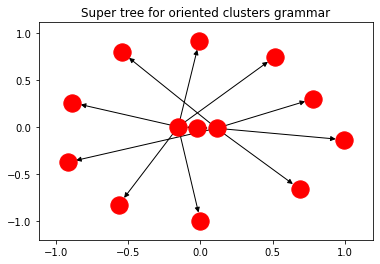

In [7]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [8]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True,
)
mip_optimized_tree = get_optimized_tree_from_mip_results(inference_results)
draw_scene_tree_contents_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip")
draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_scene_tree")

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.3224670886993408
Num vars:  2207
Num constraints:  8122
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Sep 16 22:01:02 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 6043 rows, 2247 columns and 41147 nonzeros
Model fingerprint: 0x256d1756
Model has 10 quadratic constraints
Variable types: 2158 continuous, 89 integer (89 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-16, 1e+01]
Presolve removed 5683 rows and 1887 columns
Presolve time: 0.10s
Presolved: 360 rows, 360 columns, 2081 nonzeros
Presolved model has 5 quadratic constraint(s)
Variable types: 352 continuous, 8 integer (8 binary)

Root relaxation: objective 2.140050e+00, 189 iterations, 0.01 seconds

    Nodes    |    Current No

In [10]:
# Do NLP refinement of tree
refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=True)
refined_tree = refinement_results.refined_tree
draw_scene_tree_contents_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined_scene_tree")

Success?:  True
Logfile: 

         S N O P T  7.4-1.2  (Feb 2015)
1
 
 SNMEMA EXIT 100 -- finished successfully
 SNMEMA INFO 104 -- memory requirements estimated

 
 ===>  WARNING - Column      1 of the Jacobian is empty.
 ===>  WARNING - Column      2 of the Jacobian is empty.
 ===>  WARNING - Column      3 of the Jacobian is empty.
 ===>  WARNING - Column      4 of the Jacobian is empty.
 ===>  WARNING - Column      5 of the Jacobian is empty.
 ===>  WARNING - Column      6 of the Jacobian is empty.
 ===>  WARNING - Column      7 of the Jacobian is empty.
 ===>  WARNING - Column      8 of the Jacobian is empty.
 ===>  WARNING - Column      9 of the Jacobian is empty.
 ===>  WARNING - Column     43 of the Jacobian is empty.
 ===>  WARNING - Column     44 of the Jacobian is empty.
 ===>  WARNING - Column     45 of the Jacobian is empty.
 ===>  WARNING - Column     55 of the Jacobian is empty.
 ===>  WARNING - Column     56 of the Jacobian is empty.
 ===>  WARNING - Column     57 of th

In [11]:
try:
    mip_optimized_tree.score()
except ValueError as e:
    print("MIP optimized tree wasn't happy, as expected: %s" % str(e))

print(refined_tree.score())

MIP optimized tree wasn't happy, as expected: ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f0aeee74518>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f0aeee4e908>: ', 'Child illegal rotated from parent: tensor([0.9574, 0.0000, 0.2887]) vs tensor([1., 0., 0.]), error of 16.778099 deg')
tensor([12.0600])


In [12]:
# Now try to do MCMC on the parsed tree
sampled_trees = do_fixed_structure_mcmc(grammar, tree, num_samples=100, verbose=True)

0: Accept rate 0.000000
1: Accept rate 0.000000
2: Accept rate 0.000000
3: Accept rate 0.000000
4: Accept rate 0.000000
5: Accept rate 0.000000
6: Accept rate 0.000000
7: Accept rate 0.000000
8: Accept rate 0.000000
9: Accept rate 0.000000
10: Accept rate 0.000000
11: Accept rate 0.000000
12: Accept rate 0.000000
13: Accept rate 0.000000
14: Accept rate 0.000000
15: Accept rate 0.000000
16: Accept rate 0.000000
17: Accept rate 0.000000
18: Accept rate 0.000000
19: Accept rate 0.000000
20: Accept rate 0.000000
21: Accept rate 0.000000
22: Accept rate 0.000000
23: Accept rate 0.000000
24: Accept rate 0.000000
25: Accept rate 0.000000
New score 12.060009, old score 12.060009, alpha 1.000000
26: Accept rate 0.037037
27: Accept rate 0.035714
28: Accept rate 0.034483
29: Accept rate 0.033333
30: Accept rate 0.032258
31: Accept rate 0.031250
32: Accept rate 0.030303
33: Accept rate 0.029412
34: Accept rate 0.028571
35: Accept rate 0.027778
36: Accept rate 0.027027
37: Accept rate 0.026316
38:

KeyboardInterrupt: 

In [ ]:
for sample_k, sampled_tree in enumerate(sampled_trees[::5]):
    draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sampled/%d" % sample_k)